In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from robustDA import process_cmip6, processing, anchor_regression, plots, plots_small, hypothesis_testing, utils

%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
params = {
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}",
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "xtick.minor.size": 0,
    "xtick.minor.width": 0,
}
plt.rcParams.update(params)

In [4]:
# https://github.com/Priestley-Centre/ssp_erf/tree/v3.0/SSPs

startDate, endDate = 1850, 2014
radforcing_df = pd.read_csv("./../data/local/radForcing/ERF_ssp245_1750-2500.csv", index_col=0)
radforcing_df.index.name = "Year"
radforcing_df = radforcing_df.loc[startDate:endDate]

radforcing_df_GHG = (
                radforcing_df["co2"]
                + radforcing_df["ch4"]
                + radforcing_df["n2o"]
            )
radforcing_df_co2 = radforcing_df["co2"]
radforcing_df_aerosols = (
                radforcing_df["aerosol-cloud_interactions"]
                + radforcing_df["aerosol-radiation_interactions"]
            )

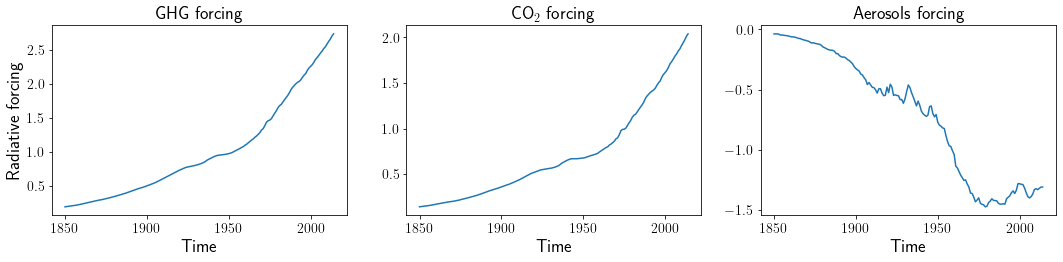

In [5]:
fig, axes = plt.subplots(1, 3, figsize = (18, 3.5))

axes[0].plot(radforcing_df_GHG)
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Radiative forcing")
axes[0].set_title("GHG forcing", )

axes[1].plot(radforcing_df_co2)
axes[1].set_xlabel("Time")
axes[1].set_title("CO$_2$ forcing")

axes[2].plot(radforcing_df_aerosols)
axes[2].set_xlabel("Time")
axes[2].set_title("Aerosols forcing")

fig.savefig("./../output/figures/radiativeForcings.pdf", bbox_inches="tight")

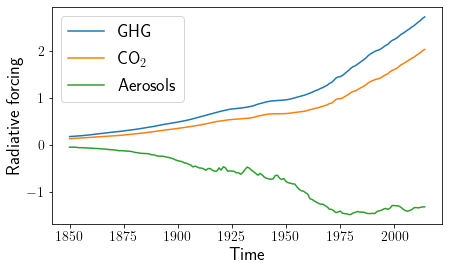

In [18]:
fig = plt.figure(figsize = (7, 4))

plt.plot(radforcing_df_GHG, label = "GHG")
plt.plot(radforcing_df_co2, label = "CO$_2$")
plt.plot(radforcing_df_aerosols, label = "Aerosols")

plt.xlabel("Time")
plt.ylabel("Radiative forcing")
plt.legend(fontsize = params["axes.labelsize"])

fig.savefig("./../output/figures/radiativeForcingsAll.svg", bbox_inches="tight")

In [22]:
params_climate = {
        "temporalRes": "ann",
        "variables": ["tas"],
        "scenarios": ["historical", "piControl"],
        "startDate": 1850,
        "endDate": 2014,
        "target": "GHG",
        "anchor": "aerosols",
    }

params_anchor = {
        "gamma": [5000],
        "h_anchors":[],
    }

In [23]:
target = params_climate["target"]
anchor = params_climate["anchor"]
startDate = params_climate["startDate"]
endDate = params_climate["endDate"]

gamma = params_anchor["gamma"]
h_anchors = params_anchor["h_anchors"]

In [24]:
modelsDataList, modelsInfoFrame = process_cmip6.read_files_cmip6(params_climate)

modelsInfoFrame.head()

,filename,var,temporalRes,modelFull,model,scenario,spatialRes
0,tas_ann_ACCESS-CM2_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,historical,g025
1,tas_ann_ACCESS-CM2_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,piControl,g025
2,tas_ann_ACCESS-ESM1-5_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,historical,g025
3,tas_ann_ACCESS-ESM1-5_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,piControl,g025
4,tas_ann_AWI-CM-1-1-MR_historical_r1i1p1f1_g025.nc,tas,ann,AWI-CM-1-1-MR,AWI,historical,g025


### Correlation maps

In [83]:
X_df = pd.DataFrame()
y_GHG_df = pd.DataFrame()
y_aer_df = pd.DataFrame()
y_co2_df = pd.DataFrame()

for i in range(len(modelsInfoFrame)):
    X_tmp = pd.DataFrame(modelsDataList[i].data)
    X_df = pd.concat([X_df, X_tmp], axis=0)
        
    startDate, endDate = (
        modelsDataList[i].data.index[0],
        modelsDataList[i].data.index[-1],
    )

    y_GHG_tmp = process_cmip6.read_forcing_cmip6(
        modelsDataList[i].scenario, "GHG", startDate, endDate
    )
    y_GHG_df = pd.concat([y_GHG_df, y_GHG_tmp], axis=0)

    y_aer_tmp = process_cmip6.read_forcing_cmip6(
        modelsDataList[i].scenario, "aerosols", startDate, endDate
    )
    y_aer_df = pd.concat([y_aer_df, y_aer_tmp], axis=0)

    y_co2_tmp = process_cmip6.read_forcing_cmip6(
        modelsDataList[i].scenario, "co2", startDate, endDate
    )
    y_co2_df = pd.concat([y_co2_df, y_co2_tmp], axis=0)


corr_map_GHG = np.zeros((X_df.shape[1],1))
for i in range(X_df.shape[1]):
    corr_map_GHG[i] = np.corrcoef(X_df.iloc[:,i], y_GHG_df.values.reshape(-1))[0,1]
    
corr_map_aer = np.zeros((X_df.shape[1],1))
for i in range(X_df.shape[1]):
    corr_map_aer[i] = np.corrcoef(X_df.iloc[:,i], y_aer_df.values.reshape(-1))[0,1]
    
corr_map_co2 = np.zeros((X_df.shape[1],1))
for i in range(X_df.shape[1]):
    corr_map_co2[i] = np.corrcoef(X_df.iloc[:,i], y_co2_df.values.reshape(-1))[0,1]

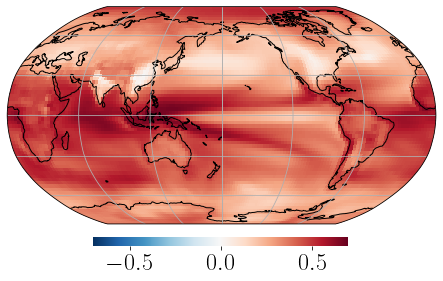

In [97]:
plots_small.plotMapCartopy(corr_map_GHG.reshape((72,144)), cLim = None)

plt.savefig("./../output/figures/corr_map_temp_GHG.svg", bbox_inches="tight")

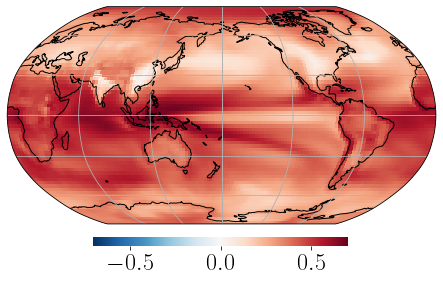

In [101]:
plots_small.plotMapCartopy(corr_map_co2.reshape((72,144)), cLim = None)

plt.savefig("./../output/figures/corr_map_temp_co2.pdf", bbox_inches="tight")

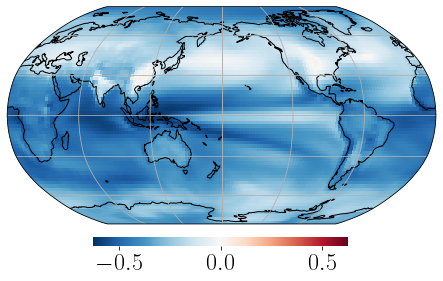

In [105]:
plots_small.plotMapCartopy(corr_map_aer.reshape((72,144)), cLim = None)

plt.savefig("./../output/figures/corr_map_temp_aer.pdf", bbox_inches="tight")